In [1]:
import pandas as pd
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TimesNet
import matplotlib.pyplot as plt

/home/maybe/miniconda3/envs/task2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-16 11:49:58,070	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-07-16 11:49:58,154	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# Загрузка данных
df = pd.read_csv('evs1_019_10_bar_harmonics_median.csv', parse_dates=['date'])

# Найдем последнюю дату в данных
last_date = df['date'].max()

# Рассчитаем первое число этого 14-дневного окна
start_date = last_date - pd.Timedelta(days=21)

# Оставим только последние 14 дней
window_df = df[(df['date'] >= start_date) & (df['date'] <= last_date)].copy()


In [3]:
window_df = window_df.rename(columns={'date': 'ds', 'value': 'y'})
window_df['unique_id'] = 'id_1'

In [4]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TimesNet

horizon = 7       # Например, прогноз на 7 дней вперёд
input_size = 14   # Используем всё 14-дневное окно

model = TimesNet(
    h=horizon,
    input_size=input_size,
    max_steps=200,
    learning_rate=1e-3,
    scaler_type='standard'
)

nf = NeuralForecast(models=[model], freq='D')  # 'D' — если ряд дневной
nf.fit(df=window_df)
forecast_df = nf.predict()


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear   

Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s, v_num=122, train_loss_step=0.00503, train_loss_epoch=0.00503]

`Trainer.fit` stopped: `max_steps=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s, v_num=122, train_loss_step=0.00503, train_loss_epoch=0.00503]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.33it/s]


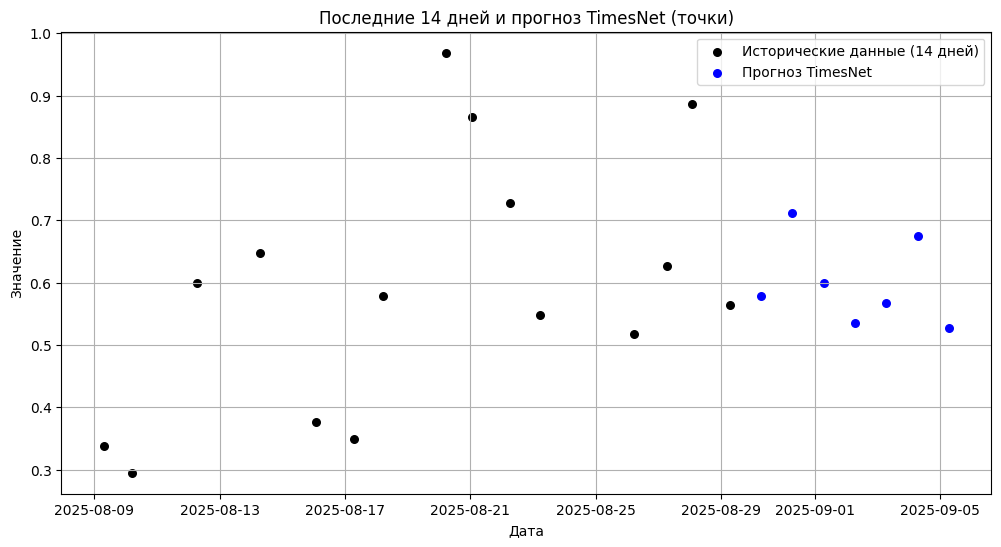

In [5]:
import matplotlib.pyplot as plt

# Истинные значения
actual = window_df.set_index('ds')['y']
# Прогноз (TimesNet)
forecast = forecast_df.set_index('ds')['TimesNet']

plt.figure(figsize=(12, 6))
plt.scatter(actual.index, actual.values, color='black', label='Исторические данные (14 дней)', s=30)
plt.scatter(forecast.index, forecast.values, color='blue', label='Прогноз TimesNet', s=30)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Последние 14 дней и прогноз TimesNet (точки)')
plt.legend()
plt.grid(True)
plt.show()
